# SEC EDGAR API 

In this notebook we explain how to use the SEC EDGAR API to access 10-Q filings of Apple filed in 2016.

A detailed documentation is hosted here: https://sec-api.io/docs

## this way of getting data is very painful:
- you get filings thought an API for given company and a given period
- then get the xlsx file from the submission page
- download the xlsx
- get the needed cell
- BUT the cells locations and names are not consistent in the xlsx files

In [11]:
# print JSON 
import time, requests
import io
import xlrd, urllib, json

def getEPS(ticker):
    print(ticker)
    TOKEN = "9a15af2a19e4d091b01c16c590aa99269cb9ab2e5739cc41986548b526f42797"
    API = "https://api.sec-api.io?token=" + TOKEN
    query = "ticker:{} AND filedAt:{{{}}} AND formType:\"10-Q\"".format(ticker, '2016-01-01 TO 2020-12-31')
    print(query)
    payload = {
      "query": { "query_string": { "query": query} },
      "from": "0",
      "size": "10",
      "sort": [{ "filedAt": { "order": "desc" } }]
    }

    # format your payload to JSON bytes
    jsondata = json.dumps(payload)
    jsondataasbytes = jsondata.encode('utf-8')   # needs to be bytes

    # instantiate the request 
    req = urllib.request.Request(API)

    # set the correct HTTP header: Content-Type = application/json
    req.add_header('Content-Type', 'application/json; charset=utf-8')
    # set the correct length of your request
    req.add_header('Content-Length', len(jsondataasbytes))

    # send the request to the API
    response = urllib.request.urlopen(req, jsondataasbytes)

    # read the response 
    res_body = response.read()
    # transform the response into JSON
    filings = json.loads(res_body.decode("utf-8"))
       
    out = []
    for n,i in enumerate(filings['filings']):
    #     print(f"{i['filedAt']}\t {i['formType']} \t {i['linkToTxt']}")
        lnk = i['linkToTxt'].rsplit('/', 1)[0] + '/Financial_Report.xlsx'
    #     print(i['filedAt'], lnk)
        file_name, headers = urllib.request.urlretrieve(lnk, f'temp_{n}.xlsx')
        wb = xlrd.open_workbook(f'temp_{n}.xlsx')
        sheet = wb.sheet_by_index(1)
        for row_num in range(100):
            row_value = sheet.cell_value(row_num, 0)
            if row_value == 'Earnings per share:':
                date = i['filedAt'].split('T')[0]
                EPS = sheet.cell_value(row_num + 1, 1)
                print (f"{i['filedAt'].split('T')[0]}  {EPS}")
                out.append(EPS)
                break  
    return out    

In [ ]:
tickers = ['AIRd', 'AYX', 'BABA', 'BXMT', 'DAL', 'IBM', 'INTC', 'JPM', 'KIM', 'RCL', 'RDSA', 'T', 'TFC', 'UNM', 'USB', 'XOM'] 
ticker = 'AAPL'
getEPS(ticker)

In [ ]:
a['filings']

# you can also try to scrape data directly from HTML, but again, this very difficult as companies do not submit consistently formatted filings

In [256]:
from bs4 import BeautifulSoup
import urllib.request
import re

cik = a['filings'][0]['cik']
an = a['filings'][0]['linkToTxt'].split('/')[-1][:-4]

url = f"https://www.sec.gov/cgi-bin/viewer?action=view&cik={cik}&accession_number={an}&xbrl_type=v"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, 'html.parser')
print(soup)

NameError: name 'a' is not defined

In [ ]:
for i in soup.body.find_all('div'):
    div = i.find('table')
    if div is not None:
        tr = div.find_all('tr')
        if tr is not None:
#             print(tr)
            td = tr[0].find_all('td')
            if td is not None:
                print(td)
        
    

# A better plan is to use the datasets from the SEC website:
- https://www.sec.gov/dera/data/financial-statement-data-sets.html

In [1]:
import pandas as pd
import os
import numpy as np
from zipfile import ZipFile
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from datetime import datetime, timedelta
import pickle

def findFuzzyMatch(name, names):
    L = []
    for b in names.to_list():
        L.append((b, fuzz.ratio(name, b)))
    L = sorted(L, key=lambda x: x[1], reverse=True)
    L = [i for i in L if i[0] != name]
    return L[0][0], L[0][1]

def get_mean_price_in_prior_month(df, ticker, date):
    date = datetime.strptime(str(date), '%Y%m%d').strftime('%Y-%m-%d')
    date1 = datetime.strptime(date, '%Y-%m-%d')
    date0 = date1 - timedelta(30)
    return df[(df.index < date1) & (df.index > date0)].MMM.to_numpy().mean().round(2)

with open('/Users/romankoshkin/Documents/КВАРТИРЫ FINANCE/INVESTMENT/FINANCIAL MODELS/snp_df.pickle', 'rb') as f:
    df = pickle.load(f)

def getIndValFromFilings(indicator, hits):
    # find all hits on the given indicator in the overall hits (on the given filing ID)
    hits_on_indicator = hits[(hits.tag == indicator)]
    # out of those, take the latest
    hits_on_indicator_latest = hits_on_indicator[hits_on_indicator.ddate == hits_on_indicator.ddate.max()]
    # out of those, take the latest for ONE latest quarter
    hits_on_indicator_latest_1Q = hits_on_indicator_latest[hits_on_indicator_latest.qtrs == hits_on_indicator_latest.qtrs.min()]
    return hits_on_indicator_latest_1Q.value.item()

In [ ]:
# DOWNLOAD AND UNZIP THE DATA

# https://www.sec.gov/files/dera/data/financial-statement-data-sets/2020q2.zip
    
for year in range(2018, 2021):
    for Q in range(1, 5):
        try:
            url = f'https://www.sec.gov/files/dera/data/financial-statement-data-sets/{year}q{Q}.zip'
            r = requests.get(url, allow_redirects=True)
            open(f'{year}q{Q}.zip', 'wb').write(r.content)

            with ZipFile(f'{year}q{Q}.zip', 'r') as zipObj:
                zipObj.extractall(f'./{year}q{Q}')
            
            os.remove(f'{year}q{Q}.zip')
        except:
            print(f'{year}q{Q}.zip doesn\'t exist')
            
    print(f'Downloading q{Q} {year} complete')

2018q1.zip doesn't exist


In [2]:
# MAKE A DATAFRAME OF SUBMISSION REFERENCES
colnames = pd.read_csv(f'/Users/romankoshkin/Downloads/{2019}q{1}/sub.txt', sep="\t").columns.to_list()
sub = pd.DataFrame(columns = colnames)
for year in range(2018, 2021):
    for Q in range(1, 4):
        if ((year==2020) & (Q > 2)):
            break
        sub = sub.append(pd.read_csv(f'/Users/romankoshkin/Downloads/{year}q{Q}/sub.txt',
                               sep="\t",
                               dtype={"aciks": "string"}),
                   ignore_index = True)
        print(year, Q)

2018 1
2018 2
2018 3
2019 1
2019 2
2019 3
2020 1
2020 2


In [3]:
import re

mylist = sub.name.to_list()
r = re.compile(".*MICROSOFT")
newlist = np.unique(list(filter(r.match, mylist)))
print(newlist)

['MICROSOFT CORP']


In [4]:
name = 'MICROSOFT CORP'
filings = sub[(sub.name==name)]
filings

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks
4489,0001564590-18-001129,789019,MICROSOFT CORP,7372.0,US,WA,REDMOND,98052-6399,ONE MICROSOFT WAY,NaN,...,20171231,2018,Q2,20180131,2018-01-31 16:10:00.0,0,1,msft-20171231.xml,1,<NA>
11696,0001564590-18-009307,789019,MICROSOFT CORP,7372.0,US,WA,REDMOND,98052-6399,ONE MICROSOFT WAY,NaN,...,20180331,2018,Q3,20180426,2018-04-26 16:10:00.0,0,1,msft-20180331.xml,1,<NA>
18452,0001564590-18-019062,789019,MICROSOFT CORP,7372.0,US,WA,REDMOND,98052-6399,ONE MICROSOFT WAY,NaN,...,20180630,2018,FY,20180803,2018-08-03 11:04:00.0,0,1,msft-20180630.xml,1,<NA>
24120,0001564590-19-001392,789019,MICROSOFT CORP,7372.0,US,WA,REDMOND,98052-6399,ONE MICROSOFT WAY,NaN,...,20181231,2019,Q2,20190130,2019-01-30 16:10:00.0,0,1,msft-20181231.xml,1,<NA>
31060,0001564590-19-012709,789019,MICROSOFT CORP,7372.0,US,WA,REDMOND,98052-6399,ONE MICROSOFT WAY,NaN,...,20190331,2019,Q3,20190424,2019-04-24 16:10:00.0,0,1,msft-20190331.xml,1,<NA>
40336,0001564590-19-027952,789019,MICROSOFT CORP,7372.0,US,WA,REDMOND,98052-6399,ONE MICROSOFT WAY,NaN,...,20190630,2019,FY,20190801,2019-08-01 16:10:00.0,0,1,msft-20190630.xml,1,<NA>
44390,0001193125-20-018383,789019,MICROSOFT CORP,7372.0,US,WA,REDMOND,98052-6399,ONE MICROSOFT WAY,NaN,...,20200131,2020,Q3,20200129,2020-01-29 16:04:00.0,0,0,d875975d8k_htm.xml,1,<NA>
44444,0001564590-20-002450,789019,MICROSOFT CORP,7372.0,US,WA,REDMOND,98052-6399,ONE MICROSOFT WAY,NaN,...,20191231,2020,Q2,20200129,2020-01-29 16:09:00.0,0,1,msft-10q_20191231_htm.xml,1,<NA>
49246,0001193125-20-050232,789019,MICROSOFT CORP,7372.0,US,WA,REDMOND,98052-6399,ONE MICROSOFT WAY,NaN,...,20200229,2020,Q3,20200226,2020-02-26 17:11:00.0,0,0,d896577d8k_htm.xml,1,<NA>
52685,0001193125-20-073072,789019,MICROSOFT CORP,7372.0,US,WA,REDMOND,98052-6399,ONE MICROSOFT WAY,NaN,...,20200229,2020,Q3,20200313,2020-03-13 17:12:00.0,0,0,d884867d8k_htm.xml,1,<NA>


In [5]:
sub

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks
0,0000002178-18-000009,2178,"ADAMS RESOURCES & ENERGY, INC.",5172.0,US,TX,HOUSTON,77027,17 S. BRIAR HOLLOW LN.,NaN,...,20171231,2017,FY,20180312,2018-03-12 17:29:00.0,0,1,ae-20171231.xml,1,<NA>
1,0000002488-18-000042,2488,ADVANCED MICRO DEVICES INC,3674.0,US,CA,SANTA CLARA,95054,2485 AUGUSTINE DRIVE,NaN,...,20171231,2017,FY,20180227,2018-02-27 16:19:00.0,0,1,amd-20171230.xml,1,<NA>
2,0000002969-18-000014,2969,AIR PRODUCTS & CHEMICALS INC /DE/,2810.0,US,PA,ALLENTOWN,18195-1501,7201 HAMILTON BLVD,NaN,...,20171231,2018,Q1,20180126,2018-01-26 12:36:00.0,0,1,apd-10qx31dec2017_htm.xml,1,<NA>
3,0000003499-18-000006,3499,ALEXANDERS INC,6798.0,US,NJ,PARAMUS,07652,210 ROUTE 4 EAST,NaN,...,20171231,2017,FY,20180212,2018-02-12 08:21:00.0,0,1,alx-20171231.xml,1,<NA>
4,0000003545-18-000021,3545,ALICO INC,100.0,US,FL,"FT. MYERS,",33913,10070 DANIELS INTERSTATE COURT STE. 100,NaN,...,20171231,2018,Q1,20180206,2018-02-06 17:07:00.0,0,1,alco-20171231.xml,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72317,0001795250-20-000005,1795250,MADISON SQUARE GARDEN ENTERTAINMENT CORP.,7900.0,US,NY,NEW YORK,10121,TWO PENNSYLVANIA PLAZA,NaN,...,2.02003e+07,2020,Q3,20200518,2020-05-15 18:10:00.0,0,1,msgentertainmentcorp10_htm.xml,1,<NA>
72318,0001800227-20-000004,1800227,"IAC HOLDINGS, INC.",5990.0,US,NY,NEW YORK,10011,555 WEST 18TH STREET,NaN,...,2.02003e+07,2020,Q1,20200603,2020-06-03 16:46:00.0,0,1,newiac-2020331x10q_htm.xml,1,<NA>
72319,0001801368-20-000002,1801368,FORTRESS VALUE ACQUISITION CORP.,6770.0,US,NY,NEW YORK,10105,1345 AVENUE OF THE AMERICAS,NaN,...,2.02003e+07,2020,Q1,20200609,2020-06-09 16:37:00.0,0,1,fortressvalueacqcorp-q_htm.xml,1,<NA>
72320,0001804220-20-000009,872589,"REGENERON PHARMACEUTICALS, INC.",2834.0,US,NY,TARRYTOWN,10591,777 OLD SAW MILL RIVER ROAD,NaN,...,2.02004e+07,NaN,NaN,20200505,2020-05-05 07:35:00.0,0,0,form8-kq12020_htm.xml,1,<NA>


In [7]:
sub[sub.name=='MCDONALDS CORP']

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks
186,0000063908-18-000010,63908,MCDONALDS CORP,5812.0,US,IL,OAK BROOK,60523,ONE MCDONALD'S PLAZA,NaN,...,20171231,2017,FY,20180223,2018-02-23 12:45:00.0,0,1,mcd-12312017x10k_htm.xml,1,<NA>
6198,0000063908-18-000025,63908,MCDONALDS CORP,5812.0,US,IL,OAK BROOK,60523,ONE MCDONALD'S PLAZA,NaN,...,20180331,2018,Q1,20180508,2018-05-08 11:55:00.0,0,1,mcd-3312018x10q_htm.xml,1,<NA>
13666,0000063908-18-000049,63908,MCDONALDS CORP,5812.0,US,IL,CHICAGO,60607,110 NORTH CARPENTER STREET,NaN,...,20180630,2018,Q2,20180802,2018-08-02 16:17:00.0,0,1,mcd-6302018x10q_htm.xml,1,<NA>
20156,0000063908-19-000010,63908,MCDONALDS CORP,5812.0,US,IL,CHICAGO,60607,110 NORTH CARPENTER STREET,NaN,...,20181231,2018,FY,20190222,2019-02-22 09:48:00.0,0,1,mcd-12312018x10k_htm.xml,1,<NA>
25887,0000063908-19-000039,63908,MCDONALDS CORP,5812.0,US,IL,CHICAGO,60607,110 NORTH CARPENTER STREET,NaN,...,20190331,2019,Q1,20190508,2019-05-08 16:38:00.0,0,1,mcd-3312019x10q_htm.xml,1,<NA>
33302,0000063908-19-000062,63908,MCDONALDS CORP,5812.0,US,IL,CHICAGO,60607,110 NORTH CARPENTER STREET,NaN,...,20190630,2019,Q2,20190806,2019-08-06 15:36:00.0,0,1,mcd-6302019x10q_htm.xml,1,<NA>
33303,0000063908-19-000066,63908,MCDONALDS CORP,5812.0,US,IL,CHICAGO,60607,110 NORTH CARPENTER STREET,NaN,...,20190731,2019,Q3,20190812,2019-08-12 16:48:00.0,0,0,form8kmainbody_htm.xml,1,<NA>
33304,0000063908-19-000070,63908,MCDONALDS CORP,5812.0,US,IL,CHICAGO,60607,110 NORTH CARPENTER STREET,NaN,...,20190930,2019,Q3,20190920,2019-09-19 18:38:00.0,0,0,form8kmainbody_htm.xml,1,<NA>
43973,0000063908-20-000005,63908,MCDONALDS CORP,5812.0,US,IL,CHICAGO,60607,110 NORTH CARPENTER STREET,NaN,...,20191130,2019,FY,20200127,2020-01-24 17:48:00.0,0,0,form8kamainbody_htm.xml,1,<NA>
44266,0000063908-20-000012,63908,MCDONALDS CORP,5812.0,US,IL,CHICAGO,60607,110 NORTH CARPENTER STREET,NaN,...,20200131,2020,Q1,20200129,2020-01-29 07:00:00.0,0,0,a8-kcoverexhibitlistin_htm.xml,1,<NA>


In [ ]:
for ticker, name in zip(['MSFT', 'MCD', 'HD', 'AAPL'], ['MICROSOFT CORP', 'MCDONALDS CORP', 'HOME DEPOT INC', 'APPLE INC']):
# for ticker, name in zip(['AAPL', 'MCD', 'DAL'], ['APPLE INC', 'MCDONALDS CORP', 'DELTA AIR LINES INC /DE/']):
    for year in range(2018, 2021):
        for Q in range(1, 4):
            print (year, Q)
            if ((year==2020) & (Q > 2)):
                break
            print(name, ticker)
            
            try:
                # get the needed filing
                filings = sub[(sub.name==name) & (sub.fy==year)  & (sub.fp==f'Q{Q}')]

                if filings.shape[0] == 0:
                    print(f'No match found on the given NAME {name}')
                    name, score = findFuzzyMatch(name, sub.name)
                    if score < 90:
                        print('Too low of a score on the match!')
                        raise Exception('Too low of a score on the match!')
                    print(f'Found a fuzzy match: {name} with score: {score}')
                    filings = sub[(sub.name==name) & (sub.fy==year)  & (sub.fp==f'Q{Q}')]
                filing_id = filings[filings.filed == filings.filed.max()].adsh.item()


                print (name, ticker, year, Q, filing_id)

                # load the dataframe that had that filing
                num = pd.read_csv(f'/Users/romankoshkin/Downloads/{year}q{Q}/num.txt', sep="\t")
                hits = num[(num.adsh==filing_id)]
                if hits.shape[0] == 0:
                    num = pd.read_csv(f'/Users/romankoshkin/Downloads/{year}q{Q+1}/num.txt', sep="\t")
                    hits = num[(num.adsh==filing_id)]


                # EPS
                indicator = 'EarningsPerShareBasic'
                EPS = getIndValFromFilings(indicator, hits)


                # P/E
                mean_share_price = get_mean_price_in_prior_month(df, name, hits.ddate.max())
                PE = np.round(mean_share_price/ EPS, 2)


                # Stockholder's Equity                  # !!!!!!!!!!!!!!!!!!!!!!!!!!! DEBUG
                indicator = 'StockholdersEquity'
                stockHoldersEquity = getIndValFromFilings(indicator, hits)


                # Common Shares
                indicator = 'EntityCommonStockSharesOutstanding'
                CommonStockSharesOutstanding = getIndValFromFilings(indicator, hits)

                indicator = 'CommonStockSharesIssued'
                try:
                    CommonStockSharesIssued = getIndValFromFilings(indicator, hits)
                except:
                    CommonStockSharesIssued = 0
                    print (f'{indicator} not found for {ticker} inQ{Q}{year}')


                # Liabilities
                for indicator in ['LiabilitiesCurrent', 'Liabilities']:
                    try:
                        print(f'Trying {indicator}')
                        Liabilities = getIndValFromFilings(indicator, hits)
                        print(f'Success')
                        break
                    except:
                        print('Failed')
                        continue


                # Assets, A/L
                indicator = 'Assets'
                Assets = getIndValFromFilings(indicator, hits)
                AL = np.round(Assets/Liabilities, 2)


                # P/B
                BVPS = np.round(stockHoldersEquity/(CommonStockSharesOutstanding + CommonStockSharesIssued), 2)
                avgPrice = get_mean_price_in_prior_month(df, name, str(hits.ddate.max()))
                PB = np.round(avgPrice/BVPS, 2)


                # Revenue
                for indicator in ['SalesRevenueNet',
                                  'RevenueFromContractWithCustomerExcludingAssessedTax',
                                  'Revenues']:
                    try:
                        print(f'Trying {indicator}')
                        netSales = getIndValFromFilings(indicator, hits)
                        print(f'Success')
                        break
                    except:
                        print('Failed')
                        continue


                # Net income
                indicator = 'NetIncomeLoss'
                netSales = getIndValFromFilings(indicator, hits)

                ROS = np.round(netIncome/netSales, 2)
                ROE = np.round(netIncome/stockHoldersEquity, 2)
                ROA = np.round(netIncome/Assets, 2)
                PS = np.round(avgPrice * (CommonStockSharesOutstanding + CommonStockSharesIssued)/netSales, 2)

                with open('DAT.txt', 'a') as f:
                    line = [str(i) for i in [ticker, ' ', year, ' ', Q, ' ', EPS, ' ', PE, ' ', PB, ' ', PS, ' ', ROS, ' ', ROA, ' ', AL]]
                    line += '\n'
                    f.writelines(line)
            except:
                with open('DAT.txt', 'a') as f:
                    m = '?'
                    line = [str(i) for i in [ticker, ' ', year, ' ', Q, ' ', m, ' ', m, ' ', m, ' ', m, ' ', m, ' ', m, ' ', m]]
                    line += '\n'
                    f.writelines(line)

In [347]:
year = 2019
Q = 2
name = 'MCDONALDS CORP'
print(year, Q)
filings = sub[(sub.name==name) & (sub.fy==year)  & (sub.fp==f'Q{Q}')]
filings

2019 2


,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks
33302,0000063908-19-000062,63908,MCDONALDS CORP,5812.0,US,IL,CHICAGO,60607,110 NORTH CARPENTER STREET,NaN,...,20190630,2019,Q2,20190806,2019-08-06 15:36:00.0,0,1,mcd-6302019x10q_htm.xml,1,<NA>


In [348]:
filing_id = filings[filings.filed == filings.filed.max()].adsh.item()
filing_id
num = pd.read_csv(f'/Users/romankoshkin/Downloads/{year}q{Q+1}/num.txt', sep="\t")

indicator = 'EntityCommonStockSharesOutstanding'
# indicator = 'EarningsPerShareBasic'
# indicator = 'StockholdersEquity'
ddate_latest = num[(num.adsh==filing_id) & (num.tag==indicator)].ddate.max()
num[(num.adsh==filing_id) & (num.tag==indicator)  & (num.ddate == ddate_latest)]



,adsh,tag,version,coreg,ddate,qtrs,uom,value,footnote
2032861,0000063908-19-000062,EntityCommonStockSharesOutstanding,dei/2019,NaN,20190630,0,shares,759444174.0,NaN


In [ ]:
# NO Q4 Q-10 filings!

import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def findFuzzyMatch(name, names):
    L = []
    for b in names.to_list():
        L.append((b, fuzz.ratio(name, b)))
    L = sorted(L, key=lambda x: x[1], reverse=True)
    L = [i for i in L if i[0] != name]
    return L[0][0]

def get_mean_price_in_prior_month(df, ticker, date):
    date = datetime.strptime(str(date), '%Y%m%d').strftime('%Y-%m-%d')
    date1 = datetime.strptime(date, '%Y-%m-%d')
    date0 = date1 - timedelta(30)
    return df[(df.index < date1) & (df.index > date0)].MMM.to_numpy().mean().round(2)

# get_mean_price_in_prior_month(df, 'AAPL', '20060630')


sub = pd.read_csv(f'/Users/romankoshkin/Downloads/{2020}q{1}/sub.txt', sep="\t")
colnames = pd.read_csv(f'/Users/romankoshkin/Downloads/{2019}q{1}/sub.txt', sep="\t").columns.to_list()
sub = pd.DataFrame(columns = colnames)
for year in range(2018, 2021):
    for Q in range(1, 4):
        if ((year==2020) & (Q > 2)):
            break
        sub = sub.append(pd.read_csv(f'/Users/romankoshkin/Downloads/{year}q{Q}/sub.txt',
                               sep="\t",
                               dtype={"aciks": "string"}),
                   ignore_index = True)
        print(year, Q)

        
for ticker, name in zip(['MCD', 'HD', 'AAPL'], ['MCDONALDS CORP', 'HOME DEPOT INC', 'APPLE INC']):
# for ticker, name in zip(['AAPL', 'MCD', 'DAL'], ['APPLE INC', 'MCDONALDS CORP', 'DELTA AIR LINES INC /DE/']):
    for year in range(2018, 2021):
        for Q in range(1, 4):
            print (year, Q)
            if ((year==2020) & (Q > 2)):
                break
            print(name, ticker)
            
            try:
                filings = sub[(sub.name==name) & (sub.fy==year)  & (sub.fp==f'Q{Q}')]
                if filings.shape[0] == 0:
                    print('!')
                    name = findFuzzyMatch(name, sub.name)
                    print(name)
                    filings = sub[(sub.name==name) & (sub.fy==year)  & (sub.fp==f'Q{Q}')]


                filings = sub[(sub.name==name) & (sub.fy==year)  & (sub.fp==f'Q{Q}')]
                filing_id = filings[filings.filed == filings.filed.max()].adsh.item()
                print(filing_id)

                indicator = 'EarningsPerShareBasic'
                num = pd.read_csv(f'/Users/romankoshkin/Downloads/{year}q{Q}/num.txt', sep="\t")
                hits = num[(num.adsh==filing_id) & (num.tag==indicator)]
                if hits.shape[0] == 0:
                    num = pd.read_csv(f'/Users/romankoshkin/Downloads/{year}q{Q+1}/num.txt', sep="\t")
                    hits = num[(num.adsh==filing_id) & (num.tag==indicator)]
                hit = hits[(hits.ddate == hits.ddate.max()) & (hits.qtrs == 1)]
                EPS = hit.value.item()


                date_ = hit.ddate.item()
                mean_share_price = get_mean_price_in_prior_month(df, name, date_)
                PE = np.round(mean_share_price/ EPS, 2)

                ddate_latest = num[(num.adsh==filing_id) & (num.tag=='StockholdersEquity')].ddate.max()
                num[(num.adsh==filing_id) & (num.tag=='StockholdersEquity') & (num.ddate==ddate_latest)].value.item()

                ddate_latest = num[(num.adsh==filing_id) & (num.tag=='StockholdersEquity')].ddate.max()
                stockHoldersEquity = num[(num.adsh==filing_id) & (num.tag=='StockholdersEquity') & (num.ddate==ddate_latest)].value.item()


                indicator = 'EntityCommonStockSharesOutstanding'
                ddate_latest = num[(num.adsh==filing_id) & (num.tag==indicator)].ddate.max()
                CommonStockSharesOutstanding = num[(num.adsh==filing_id) & (num.tag==indicator)  & (num.ddate == ddate_latest)].value.item()

                indicator = 'CommonStockSharesIssued'
                if not num[(num.adsh==filing_id) & (num.tag==indicator)].shape[0] == 0:
                    ddate_latest = num[(num.adsh==filing_id) & (num.tag==indicator)].ddate.max()
                    CommonStockSharesIssued = num[(num.adsh==filing_id) & (num.tag==indicator)  & (num.ddate == ddate_latest)].value.item()
                else:
                    CommonStockSharesIssued = 0


                for indicator in ['LiabilitiesCurrent',
                                  'Liabilities']:
                    if num[(num.adsh==filing_id) & (num.tag==indicator)].shape[0] == 0:
                        continue
                    else:
                        ddate_max = (num[(num.adsh==filing_id) & (num.tag==indicator)]).ddate.max()
                        Liabilities = num[(num.adsh==filing_id) & (num.tag==indicator) & (num.ddate == ddate_max)].value.item()
                        break


                ddate_max = (num[(num.adsh==filing_id) & (num.tag=='Assets')]).ddate.max()
                Assets = num[(num.adsh==filing_id) & (num.tag=='Assets') & (num.ddate == ddate_max)].value.item()
                AL = np.round(Assets/Liabilities, 2)

                BVPS = np.round(stockHoldersEquity/(CommonStockSharesOutstanding + CommonStockSharesIssued), 2)
                avgPrice = get_mean_price_in_prior_month(df, name, str(ddate_latest))

                PB = np.round(avgPrice/BVPS, 2)



                for indicator in ['SalesRevenueNet',
                                  'RevenueFromContractWithCustomerExcludingAssessedTax',
                                  'Revenues']:
                    if num[(num.adsh==filing_id) & (num.tag==indicator)].shape[0] == 0:
                        continue
                    else:
                        ddate_max = (num[(num.adsh==filing_id) & (num.tag==indicator)]).ddate.max()
                        qtrs_min = (num[(num.adsh==filing_id) & (num.tag==indicator)]).qtrs.min()

                        netSales = num[(num.adsh==filing_id) & 
                                       (num.tag==indicator) & 
                                       (num.ddate == ddate_max) &
                                       (num.qtrs == qtrs_min)].value.item()
                        print(netSales)
                        break



                indicator = 'NetIncomeLoss'
                ddate_max = (num[(num.adsh==filing_id) & (num.tag==indicator)]).ddate.max()
                netIncome = num[(num.adsh==filing_id) & (num.tag==indicator) & (num.ddate == ddate_max)].value.min()

                ROS = np.round(netIncome/netSales, 2)

                ROE = np.round(netIncome/stockHoldersEquity, 2)

                ROA = np.round(netIncome/Assets, 2)

                PS = np.round(avgPrice * (CommonStockSharesOutstanding + CommonStockSharesIssued)/netSales, 2)

                with open('DAT.txt', 'a') as f:
                    line = [str(i) for i in [ticker, ' ', year, ' ', Q, ' ', EPS, ' ', PE, ' ', PB, ' ', PS, ' ', ROS, ' ', ROA, ' ', AL]]
                    line += '\n'
                    f.writelines(line)
            except:
                with open('DAT.txt', 'a') as f:
                    m = '?'
                    line = [str(i) for i in [ticker, ' ', year, ' ', Q, ' ', m, ' ', m, ' ', m, ' ', m, ' ', m, ' ', m, ' ', m]]
                    line += '\n'
                    f.writelines(line)
                


In [86]:
df

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AAP,AMD,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
,,,,,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-30,72.879997,7.193333,20.511450,33.625000,10.850,31.245000,6.942500,39.674999,43.075001,40.630001,...,64.269999,19.335,36.903820,28.895000,23.07,17.873832,44.865000,70.230000,79.674999,28.355000
2006-01-31,72.605000,7.184167,20.434682,33.625000,10.780,31.749999,7.052500,39.555000,43.245001,41.250000,...,64.730003,19.375,37.378130,28.469999,23.07,17.765996,44.975000,70.474998,79.139999,28.355000
2006-02-01,72.705002,6.959167,20.631400,33.625000,11.010,31.525001,7.120000,39.879999,43.439999,41.350000,...,65.275002,19.410,37.786562,28.100000,23.07,17.873832,44.470001,69.000000,79.219997,28.355000
2006-02-02,72.865002,7.068333,20.487460,33.625000,10.965,31.770000,7.015000,39.490002,42.840000,41.519999,...,64.579998,19.030,37.839262,27.960000,23.07,18.046370,43.825001,67.809998,78.585003,28.355000
2006-02-03,71.544998,7.045000,20.410691,33.625000,10.815,31.500000,7.065000,38.910000,42.930000,40.269999,...,63.220001,18.880,37.470356,27.470000,23.07,18.044572,42.970001,67.535000,78.299999,28.355000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-21,161.715004,48.870001,101.689999,94.820000,4.920,236.650002,83.410000,473.809998,25.165000,83.320004,...,83.340000,16.240,18.650001,101.250000,23.07,95.825001,16.775001,32.065000,31.830001,158.205002
2020-08-24,162.549995,49.485001,101.965000,94.709999,4.920,237.605003,82.785004,474.769989,25.165000,83.940002,...,84.099998,16.240,19.205000,102.520000,23.07,96.070000,16.775001,32.065000,32.300001,157.980003


In [105]:
ticker = 'MCD'
date = '20140331'
date = datetime.strptime(str(date), '%Y%m%d').strftime('%Y-%m-%d')
date1 = datetime.strptime(date, '%Y-%m-%d')
date0 = date1 - timedelta(days=10)
print('date1', date1)
print('date0', date0)

date1 2014-03-31 00:00:00
date0 2014-03-21 00:00:00


In [91]:
np.unique(dd.fiscal_year.to_list()).tolist()

[2010, 2011]

In [6]:
np.unique(dd.fiscal_year.values)

array([1215, 1216, 1217, 1218, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020])

In [12]:
dd[(dd.symbol == 'IPG') & (dd.fiscal_year == 2018)]

,symbol,end_date,period_focus,fiscal_year,doc_type,revenues,net_income,eps_basic,dividend,assets,cur_assets,cur_liab,equity,shares_outstanding,shares_issued
7982,IPG,2018-06-30,Q2,2018,10-Q,2.391800e+09,145800000.0,0.38,0.21,1.235760e+10,7.145600e+09,7.585300e+09,2.091600e+09,383785420.0,390500000.0
7984,IPG,2018-09-30,Q3,2018,10-Q,2.297500e+09,161000000.0,0.42,0.21,1.351310e+10,8.330500e+09,6.691700e+09,2.170200e+09,384351500.0,391100000.0
7990,IPG,2018-03-31,Q1,2018,10-Q,1.774000e+09,-14100000.0,-0.04,0.21,1.224010e+10,6.963500e+09,7.322500e+09,2.140300e+09,385519753.0,390300000.0


# As you can see above, this is still a BIG pain in the ass.

# And this approach - pystock-crawler (see github) is much better

In [ ]:
if 'dd' in locals():
    del(dd)

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import pickle
from datetime import datetime, timedelta
import os
import json

with open('/Users/romankoshkin/Documents/КВАРТИРЫ FINANCE/INVESTMENT/FINANCIAL MODELS/snp.json') as json_file:
    snp = json.load(json_file)
snp = pd.DataFrame(snp)

with open('/Users/romankoshkin/Documents/КВАРТИРЫ FINANCE/INVESTMENT/FINANCIAL MODELS/snp_df.pickle', 'rb') as f:
    df = pickle.load(f)
    


dd = pd.read_csv('out.csv').drop(columns=['amend', 'eps_diluted', 'cash', 'cash_flow_inv', 'cash_flow_fin', 'cash_flow_op', 'op_income'])

dd.at[dd.fiscal_year == 1215] = 2015
dd.at[dd.fiscal_year == 1216] = 2016
dd.at[dd.fiscal_year == 1217] = 2017
dd.at[dd.fiscal_year == 1218] = 2018

uq_sym = np.unique(dd.symbol.to_list())
uq_fy = np.unique(dd.fiscal_year.to_list()).tolist()

In [2]:
msng = np.zeros((len(uq_sym), len(uq_fy)))

for ify, fy in enumerate(uq_fy):
    for isym, sym in enumerate(uq_sym):
        so = dd[(dd.symbol == sym) & (dd.fiscal_year == fy) & (dd.period_focus == 'FY')].shares_outstanding.to_list()
        if (len(so) != 0):
            if so[0] != so[0]:
                so_q3 = dd[(dd.symbol == sym) & (dd.fiscal_year == fy) & (dd.period_focus == 'Q3')].shares_outstanding.to_list()
                if len(so_q3) != 0:
                    msng[isym, ify] = 1
                    dd.at[(dd.symbol == sym) & (dd.fiscal_year == fy) & (dd.period_focus == 'FY'), 'shares_outstanding'] = so_q3[0]
                    print(f'fixed: {sym} {fy}')
                else:
                    msng[isym, ify] = 2
                    print(f'Could\'t fix {sym} {fy}')
        else:
            msng[isym, ify] = 3
            
dd = dd[dd.symbol != 'GOOG/GOOGL']
dd.to_pickle("dd.pkl")

Could't fix AA 2010
Could't fix ABT 2010
Could't fix ADBE 2010
Could't fix ADS 2010
Could't fix AEE 2010
Could't fix AES 2010
Could't fix AFL 2010
Could't fix AIG 2010
Could't fix AIV 2010
Could't fix AIZ 2010
Could't fix AJG 2010
Could't fix AKAM 2010
Could't fix ALB 2010
Could't fix ALGN 2010
Could't fix ALK 2010
Could't fix ALL 2010
Could't fix ALXN 2010
Could't fix AMB 2010
Could't fix AMD 2010
Could't fix AME 2010
Could't fix AMGN 2010
Could't fix AMP 2010
Could't fix AMR 2010
Could't fix AMT 2010
Could't fix ANSS 2010
Could't fix AON 2010
Could't fix AOS 2010
Could't fix APA 2010
Could't fix APH 2010
Could't fix ARE 2010
Could't fix ATVI 2010
Could't fix AVB 2010
Could't fix AWK 2010
Could't fix AXP 2010
Could't fix BA 2010
Could't fix BAC 2010
Could't fix BAX 2010
Could't fix BBT 2010
Could't fix BIIB 2010
Could't fix BK 2010
Could't fix BLK 2010
Could't fix BMY 2010
Could't fix BSX 2010
Could't fix BWA 2010
Could't fix BXP 2010
Could't fix C 2010
Could't fix CBG 2010
Could't fi

fixed: EW 2011
fixed: EXPD 2011
fixed: EXR 2011
fixed: F 2011
fixed: FAST 2011
fixed: FBHS 2011
fixed: FCX 2011
fixed: FDX 2011
fixed: FE 2011
fixed: FFIV 2011
fixed: FIS 2011
fixed: FISV 2011
fixed: FLIR 2011
fixed: FLS 2011
fixed: FLT 2011
fixed: FRT 2011
fixed: FTNT 2011
fixed: GE 2011
fixed: GILD 2011
fixed: GIS 2011
fixed: GLW 2011
fixed: GM 2011
fixed: GPC 2011
fixed: GPN 2011
fixed: GPS 2011
fixed: GRMN 2011
fixed: GS 2011
fixed: HAL 2011
fixed: HAS 2011
fixed: HBI 2011
fixed: HCA 2011
fixed: HCN 2011
fixed: HCP 2011
fixed: HD 2011
fixed: HIG 2011
fixed: HII 2011
fixed: HOC 2011
fixed: HOG 2011
fixed: HOLX 2011
fixed: HON 2011
fixed: HPQ 2011
fixed: HRB 2011
fixed: HRL 2011
fixed: HRS 2011
fixed: HSIC 2011
fixed: HST 2011
fixed: HSY 2011
fixed: HUM 2011
fixed: IBM 2011
fixed: IDXX 2011
fixed: IEX 2011
fixed: IFF 2011
fixed: ILMN 2011
fixed: INCY 2011
fixed: INTC 2011
fixed: INTU 2011
fixed: IP 2011
fixed: IPG 2011
fixed: IPGP 2011
fixed: IR 2011
fixed: IRM 2011
fixed: IT 2011
fi

fixed: MRO 2012
fixed: MS 2012
fixed: MSCI 2012
fixed: MSI 2012
fixed: MTB 2012
fixed: MTD 2012
fixed: MU 2012
fixed: MXIM 2012
fixed: NDAQ 2012
fixed: NEE 2012
fixed: NEM 2012
fixed: NKE 2012
fixed: NLSN 2012
fixed: NOC 2012
fixed: NOV 2012
fixed: NOW 2012
fixed: NRG 2012
fixed: NSC 2012
fixed: NTAP 2012
fixed: NTRS 2012
fixed: NU 2012
fixed: NUE 2012
fixed: NVDA 2012
fixed: NVR 2012
fixed: NWL 2012
fixed: O 2012
fixed: ODFL 2012
fixed: OKE 2012
fixed: OMC 2012
fixed: ORLY 2012
fixed: OXY 2012
fixed: PAYX 2012
fixed: PBCT 2012
fixed: PCAR 2012
fixed: PCLN 2012
fixed: PCS 2012
fixed: PEG 2012
fixed: PEP 2012
fixed: PFE 2012
fixed: PFG 2012
fixed: PG 2012
fixed: PGR 2012
fixed: PH 2012
fixed: PKG 2012
fixed: PKI 2012
fixed: PLD 2012
fixed: PM 2012
fixed: PNC 2012
fixed: PNW 2012
fixed: PPG 2012
fixed: PPL 2012
fixed: PRU 2012
fixed: PSA 2012
fixed: PSX 2012
fixed: PVH 2012
fixed: PWR 2012
fixed: PXD 2012
fixed: QCOM 2012
fixed: RCL 2012
fixed: RE 2012
fixed: REG 2012
fixed: REGN 2012
fi

fixed: UPS 2013
fixed: USB 2013
fixed: UTX 2013
fixed: V 2013
fixed: VAR 2013
fixed: VEL - PE 2013
fixed: VLO 2013
fixed: VMC 2013
fixed: VRSK 2013
fixed: VRSN 2013
fixed: VRTX 2013
fixed: VTR 2013
fixed: VZ 2013
fixed: WAB 2013
fixed: WAT 2013
fixed: WDC 2013
fixed: WEC 2013
fixed: WFC 2013
fixed: WHR 2013
fixed: WLP 2013
fixed: WM 2013
fixed: WMB 2013
fixed: WMT 2013
Could't fix WRB 2013
fixed: WSH 2013
fixed: WST 2013
fixed: WU 2013
fixed: WY 2013
fixed: WYNN 2013
fixed: XEL 2013
fixed: XLNX 2013
fixed: XOM 2013
fixed: XRAY 2013
fixed: XYL 2013
fixed: A 2014
fixed: AA 2014
Could't fix AAL 2014
fixed: AAP 2014
fixed: ABBV 2014
fixed: ABC 2014
fixed: ABMD 2014
fixed: ABT 2014
fixed: ACE 2014
fixed: ACN 2014
fixed: ADBE 2014
fixed: ADM 2014
fixed: ADP 2014
fixed: ADS 2014
fixed: AEE 2014
fixed: AES 2014
fixed: AFL 2014
fixed: AIG 2014
fixed: AIV 2014
fixed: AIZ 2014
fixed: AJG 2014
fixed: AKAM 2014
fixed: ALB 2014
fixed: ALGN 2014
fixed: ALK 2014
fixed: ALL 2014
fixed: ALLE 2014
fixed:

fixed: CHRW 2015
fixed: CINF 2015
fixed: CL 2015
fixed: CLX 2015
fixed: CMA 2015
fixed: CME 2015
fixed: CMI 2015
fixed: CNC 2015
fixed: CNP 2015
fixed: COG 2015
fixed: COH 2015
fixed: COO 2015
fixed: COP 2015
fixed: COST 2015
fixed: COTY 2015
fixed: CPB 2015
fixed: CPRT 2015
fixed: CSCO 2015
fixed: CTAS 2015
fixed: CTL 2015
fixed: CTSH 2015
fixed: CTXS 2015
fixed: CVS 2015
fixed: CVX 2015
fixed: CXO 2015
fixed: D 2015
fixed: DAL 2015
fixed: DE 2015
fixed: DFS 2015
fixed: DG 2015
fixed: DGX 2015
fixed: DHI 2015
fixed: DHR 2015
fixed: DISCA 2015
fixed: DISH 2015
fixed: DLR 2015
fixed: DLTR 2015
fixed: DPZ 2015
fixed: DRE 2015
fixed: DUK 2015
fixed: DVN 2015
fixed: DXCM 2015
fixed: EA 2015
fixed: EFX 2015
fixed: EIX 2015
fixed: EL 2015
fixed: EMR 2015
fixed: EOG 2015
fixed: EQR 2015
fixed: ES 2015
fixed: ESS 2015
fixed: ETFC 2015
fixed: ETN 2015
fixed: EW 2015
fixed: EXC 2015
fixed: EXPD 2015
fixed: EXR 2015
fixed: F 2015
fixed: FANG 2015
fixed: FBHS 2015
fixed: FCX 2015
fixed: FDX 2015
f

fixed: IRM 2016
fixed: IT 2016
fixed: ITW 2016
fixed: IVZ 2016
fixed: JBHT 2016
Could't fix JCI 2016
fixed: JEC 2016
fixed: JKHY 2016
fixed: JNJ 2016
fixed: JNPR 2016
fixed: JPM 2016
fixed: JWN 2016
fixed: KEY 2016
fixed: KEYS 2016
fixed: KHC 2016
fixed: KIM 2016
fixed: KMB 2016
fixed: KMI 2016
fixed: KMX 2016
fixed: KO 2016
fixed: KR 2016
fixed: KSS 2016
fixed: L 2016
fixed: LB 2016
fixed: LDOS 2016
fixed: LEG 2016
fixed: LH 2016
fixed: LKQ 2016
fixed: LLY 2016
fixed: LNC 2016
fixed: LNT 2016
fixed: LOW 2016
fixed: LRCX 2016
fixed: LUV 2016
fixed: LVS 2016
fixed: LYB 2016
fixed: LYV 2016
fixed: MA 2016
fixed: MAA 2016
fixed: MAR 2016
fixed: MAS 2016
fixed: MCD 2016
fixed: MCHP 2016
fixed: MCK 2016
fixed: MCO 2016
fixed: MDLZ 2016
fixed: MDT 2016
fixed: MET 2016
fixed: MGM 2016
fixed: MHK 2016
fixed: MKC 2016
fixed: MKTX 2016
fixed: MLM 2016
fixed: MMC 2016
fixed: MMM 2016
fixed: MNST 2016
fixed: MO 2016
fixed: MOS 2016
fixed: MPC 2016
fixed: MRK 2016
fixed: MRO 2016
fixed: MS 2016
fix

fixed: PEG 2017
fixed: PEP 2017
Could't fix PFE 2017
fixed: PFG 2017
fixed: PG 2017
fixed: PGR 2017
fixed: PH 2017
fixed: PHM 2017
fixed: PKG 2017
fixed: PKI 2017
fixed: PLD 2017
fixed: PM 2017
fixed: PNC 2017
fixed: PNW 2017
fixed: PPG 2017
fixed: PPL 2017
fixed: PRGO 2017
fixed: PRU 2017
fixed: PSA 2017
fixed: PSX 2017
fixed: PVH 2017
fixed: PWR 2017
fixed: PX 2017
fixed: PXD 2017
fixed: PYPL 2017
fixed: QCOM 2017
fixed: RCL 2017
fixed: RE 2017
fixed: REG 2017
fixed: REGN 2017
fixed: RF 2017
fixed: RFMD 2017
fixed: RHI 2017
fixed: RJF 2017
fixed: RL 2017
fixed: ROK 2017
fixed: ROL 2017
fixed: ROP 2017
fixed: ROST 2017
fixed: RSG 2017
fixed: SBAC 2017
fixed: SBUX 2017
fixed: SCHW 2017
fixed: SEE 2017
fixed: SHW 2017
fixed: SIVB 2017
fixed: SJM 2017
fixed: SLG 2017
fixed: SNA 2017
fixed: SNPS 2017
fixed: SO 2017
fixed: SPG 2017
Could't fix SRE 2017
fixed: STT 2017
fixed: STX 2017
fixed: STZ 2017
Could't fix SWK 2017
fixed: SWKS 2017
fixed: SYF 2017
fixed: SYK 2017
fixed: SYY 2017
fixed

In [4]:
dd = pd.read_pickle("dd.pkl")

In [5]:
dd.head()

,symbol,end_date,period_focus,fiscal_year,doc_type,revenues,net_income,eps_basic,dividend,assets,cur_assets,cur_liab,equity,shares_outstanding,shares_issued
0,AOS,2010-12-31,FY,2010,10-K,1.489300e+09,111700000.0,2.44,0.00,2.112000e+09,8.960000e+08,5.368000e+08,8.814000e+08,NaN,40195162.0
1,AOS,2011-06-30,Q2,2011,10-Q,4.053000e+08,50300000.0,1.09,0.14,2.143100e+09,9.912000e+08,5.359000e+08,9.698000e+08,NaN,40421725.0
2,AOS,2011-03-31,Q1,2011,10-Q,4.174000e+08,41000000.0,0.89,0.14,2.205300e+09,9.870000e+08,5.554000e+08,9.219000e+08,NaN,40197482.0
3,APD,2011-03-31,Q2,2011,10-Q,2.501300e+09,304300000.0,1.42,0.58,1.382070e+10,2.976500e+09,2.211300e+09,5.999200e+09,211896649.0,249455584.0
4,APD,2010-12-31,Q1,2011,10-Q,2.391700e+09,268600000.0,1.25,0.49,1.345970e+10,2.870200e+09,1.937100e+09,5.977200e+09,214919795.0,249455584.0


In [11]:
import re
import requests

def get_base_url(ticker):
    full_link = df[df.ticker == ticker].link.item().split('=\'')[1].split('\'>')[0]
    return '/'.join(full_link.split('/')[:-1])

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def get_financial_ratios(ticker, df):
    full_link = df[df.ticker == ticker].link.item().split('=\'')[1].split('\'>')[0]
    url = '/'.join(full_link.split('/')[:-1]) + '/financial-ratios'
    r = requests.get(url)
    t = r.text

    l = t.split('var originalData = ')
    l = l[1].split(']')
    l = l[0] + ']'

    freeFromTags = cleanhtml(l)
    return json.loads(freeFromTags)

In [24]:
ACC = []
tickers = df.ticker.to_list()[:30]
for i, ticker in enumerate(tickers):
    try:
        print(f'{i} of {len(tickers)}')
        tmp = get_financial_ratios(ticker, df)
        for i, dic in enumerate(tmp):
            tmp[i]['popup_icon'] = ticker
        ACC += tmp   
    except:
        print('User interrupt or error')
        break
    
# DE, CR, ROE, ROA, ROI, BVPS, net_profit
fr = pd.DataFrame(ACC)

dropcols = [i for i in fr.columns.to_list() if not '-12-31' in i][2:]
fr.drop(columns = dropcols, inplace=True)
fr

0 of 30
1 of 30
2 of 30
3 of 30
4 of 30
5 of 30
6 of 30
7 of 30
8 of 30
9 of 30
10 of 30
11 of 30
12 of 30
13 of 30
14 of 30
15 of 30
16 of 30
17 of 30
18 of 30
19 of 30
20 of 30
21 of 30
22 of 30
23 of 30
24 of 30
25 of 30
26 of 30
27 of 30
28 of 30
29 of 30


,field_name,popup_icon,2019-12-31,2018-12-31,2017-12-31,2016-12-31,2015-12-31,2014-12-31,2013-12-31,2012-12-31,2011-12-31,2010-12-31,2009-12-31,2008-12-31,2007-12-31,2006-12-31,2005-12-31
0,Current Ratio,GOOG,3.37410,3.91900,5.14030,6.29080,4.66670,4.68780,4.58170,4.21660,5.91920,4.15790,10.61780,8.76520,8.49340,9.99540,12.07580
1,Long-term Debt / Capital,GOOG,0.02210,0.02210,0.02540,0.02750,0.01630,0.03010,0.02500,0.04000,0.04880,,,,,,
2,Debt/Equity Ratio,GOOG,0.02260,0.02260,0.02600,0.02830,0.04340,0.05040,0.06010,0.07720,0.07230,0.07490,,,,,
3,Gross Margin,GOOG,55.58050,56.47610,58.88050,61.07540,62.44250,61.07480,60.38650,62.69250,65.20780,64.47260,62.60620,60.44230,59.93080,60.15980,58.01800
4,Operating Margin,GOOG,21.14890,20.11710,23.61460,26.27170,25.81710,24.99360,27.74370,30.04840,30.97740,35.40470,35.14440,30.42760,30.64000,33.47500,32.86240
5,EBIT Margin,GOOG,21.14890,20.11710,23.61460,26.27170,25.81710,24.99360,27.74370,30.04840,30.97740,35.40470,35.14440,30.42760,30.64000,33.47500,32.86240
6,EBITDA Margin,GOOG,28.42760,26.72070,29.85250,33.07780,32.56880,32.53740,34.83850,36.48210,35.86070,40.16580,41.58810,37.30960,36.47140,38.86820,37.64870
7,Pre-Tax Profit Margin,GOOG,24.48150,25.51770,24.53020,26.75250,26.20520,26.14960,28.63700,31.42770,32.51810,36.82000,35.43610,26.85360,34.19300,37.82240,34.88890
8,Net Profit Margin,GOOG,21.21810,22.46470,11.42210,21.57700,21.10440,21.41790,22.93450,23.32150,25.68790,29.00650,27.56750,19.39350,25.33280,29.01900,23.87200
9,Asset Turnover,GOOG,0.58660,0.58770,0.56190,0.53890,0.50850,0.51090,0.50050,0.49080,0.52230,0.50680,0.58400,0.68610,0.65500,0.57410,0.59760


In [33]:
def get_mean_price_in_prior_month(df, ticker, date):
    try:
        date = datetime.strptime(str(date), '%Y%m%d').strftime('%Y-%m-%d')
        date1 = datetime.strptime(date, '%Y-%m-%d')
        date0 = date1 - timedelta(days=10)
        price = df[(date0 < df.index) & (df.index < date1)][ticker].to_numpy().mean().round(2)
    except:
        print(date)
    return 1


def add_avg_price(dd):
    tmp = []
    for i in range(dd.shape[0]):
        try:
            date = dd.iloc[i].end_date.replace('-', '')
        except:
            print(dd.iloc[i].end_date)
        sym = dd.iloc[i].symbol
        tmp.append(get_mean_price_in_prior_month(df, sym, date))
    dd['avgPr'] = tmp
    
def add_PE(dd):
    tmp = []
    for i in range(dd.shape[0]):
        tmp.append(round(dd.iloc[i].avgPr/(dd.iloc[i].eps_basic), 2))
    dd['PE'] = tmp

def add_BVPS(dd):
    tmp = []
    for i in range(dd.shape[0]):
#         tmp.append(dd.iloc[i].equity/(dd.iloc[i].shares_outstanding + dd.iloc[i].shares_issued))
        tmp.append(round(dd.iloc[i].equity/(dd.iloc[i].shares_outstanding), 2))
    dd['BVPS'] = tmp
    
def add_PB(dd):
    tmp = []
    for i in range(dd.shape[0]):
        tmp.append(round(dd.iloc[i].avgPr/dd.iloc[i].BVPS, 2))
    dd['PB'] = tmp

def add_LA(dd):
    tmp = []
    for i in range(dd.shape[0]):
        tmp.append(round(dd.iloc[i].cur_liab/dd.iloc[i].cur_assets, 2))
    dd['LA'] = tmp
    
def add_ROS(dd):
    tmp = []
    for i in range(dd.shape[0]):
        tmp.append(dd.iloc[i].net_income/dd.iloc[i].revenues)
    dd['ROS'] = tmp

def add_ROE(dd):
    tmp = []
    for i in range(dd.shape[0]):
        tmp.append(round(dd.iloc[i].net_income/dd.iloc[i].equity, 2))
    dd['ROE'] = tmp
    
def add_ROA(dd):
    tmp = []
    for i in range(dd.shape[0]):
        tmp.append(round(dd.iloc[i].net_income/dd.iloc[i].cur_assets, 2))
    dd['ROA'] = tmp
    
def add_PS(dd):
    tmp = []
    for i in range(dd.shape[0]):
        tmp.append(round(dd.iloc[i].avgPr/(dd.iloc[i].revenues/dd.iloc[i].shares_outstanding), 2))
#         tmp.append(round(dd.iloc[i].equity/(dd.iloc[i].shares_outstanding), 2))
    dd['PS'] = tmp

def add_DE(dd):
    tmp = []
    for i in range(dd.shape[0]):
        assets = dd.iloc[i].assets.item()
        equity = dd.iloc[i].equity.item()
        liability = assets - equity
        DE = liability/equity
        tmp.append(np.round(DE, 2))
    dd['DE'] = tmp

def addIndustry():
    IND = []
    global dd, snp
    for sym in dd.symbol:
        ind = snp[snp.Symbol == sym].Sector.item()
        IND.append(ind)
    dd['ind'] = IND
    
def add_CurrRat():
    global dd
    tmp = []
    for i in range(dd.shape[0]):
        c_assets = dd.iloc[i].cur_assets.item()
        c_liabilities = dd.iloc[i].cur_liab.item()
        CR = c_assets/c_liabilities 
        tmp.append(np.round(CR, 2))
    dd['CurrRat'] = tmp
    
def add_ProfitMargin():
    global dd
    tmp = []
    for i in range(dd.shape[0]):
        net_income = dd.iloc[i].net_income.item()
        revenues = dd.iloc[i].revenues.item()
        PM = net_income/revenues
        tmp.append(np.round(PM, 2))
    dd['ProfitMargin'] = tmp
    
def get_profitability(ticker, y_st, n):
    """ returns % ROI per annum """
    global df
    date = datetime.strptime(str(str(y_st)+'0101'), '%Y%m%d').strftime('%Y-%m-%d')
    date0 = datetime.strptime(date, '%Y-%m-%d')
    date1 = date0 + timedelta(days=n*365+2)

    id0 = np.argmin(np.abs(df.index - date0))
    id1 = np.argmin(np.abs(df.index - date1))
    return np.round((df.iloc[id1][ticker].item() - df.iloc[id0][ticker].item())/df.iloc[id0][ticker].item() * 100 / n, 2)

In [34]:
add_avg_price(dd)
add_BVPS(dd)

# The P/E ratio can be viewed as the number of years it takes for the company to earn back 
# the price you pay for the stock. Therefore, lower-P/E stocks are more attractive than higher 
# P/E stocks so long as the P/E ratio is positive. Also for stocks with the same P/E ratio, 
# the one with faster growth business is more attractive
add_PE(dd)


add_PB(dd)
add_LA(dd)
add_ROS(dd)
add_ROE(dd)
add_ROA(dd)
add_PS(dd)
add_DE(dd)
addIndustry()
add_CurrRat()
add_ProfitMargin()

dd = dd.sort_values(by=['symbol', 'fiscal_year', 'period_focus'])

# dd.rename(columns={'symbol': 'sym',
#  'end_date': 'end',
#  'period_focus': 'Q',
#  'fiscal_year': 'FY',
#  'doc_type': 'doc',
#  'revenues':'rev',
#  'net_income': 'net_inc',
#  'eps_basic': 'eps_b',
#  'dividend': 'div',
#  'assets': 'ass',
#  'cur_assets': 'curr_ass',
#  'shares_outstanding': 'sh_out',
#  'shares_issued': 'sha_iss'}, inplace=True)


# dd1 = dd[dd.Q == 'FY']
# dd1 = dd1.sort_values(by=['sym', 'FY'])

# dd1

2011-03-31
2010-12-31
2011-12-31
2012-12-31
2012-12-31
2013-12-31
2011-09-30
2011-06-30
2012-09-30
2014-09-30
2014-03-31
2014-06-30
2013-06-30
2013-03-31
2013-09-30
2012-03-31
2012-06-30
2011-06-30
2011-03-31
2011-09-30
2010-12-31
2012-03-31
2012-06-30
2013-03-31
2013-06-30
2012-09-30
2011-12-31
2012-12-31
2014-03-31
2013-12-31
2013-09-30
2014-09-30
2014-06-30
2012-03-31
2012-06-30
2012-09-30
2012-12-31
2014-06-30
2014-03-31
2013-06-30
2013-09-30
2013-12-31
2013-03-31
2014-09-30
2016-03-31
2016-06-30
2015-12-31
2015-03-31
2017-03-31
2017-06-30
2016-09-30
2015-09-30
2017-09-30
2014-12-31
2016-12-31
2015-06-30
2017-06-30
2018-03-31
2017-09-30
2018-06-30
2018-09-30
2017-12-31
2013-05-31
2014-02-28
2013-11-30
2014-05-31
2014-08-31
2010-12-31
2011-03-31
2011-06-30
2013-06-30
2012-12-31
2013-12-31
2011-12-31
2014-03-31
2013-03-31
2012-06-30
2013-09-30
2011-09-30
2012-03-31
2012-12-31
2012-09-30
2015-06-30
2014-09-30
2014-06-30
2015-03-31
2014-12-31
2016-03-31
2015-12-31
2017-03-31
2016-06-30

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_sc

ZeroDivisionError: float division by zero

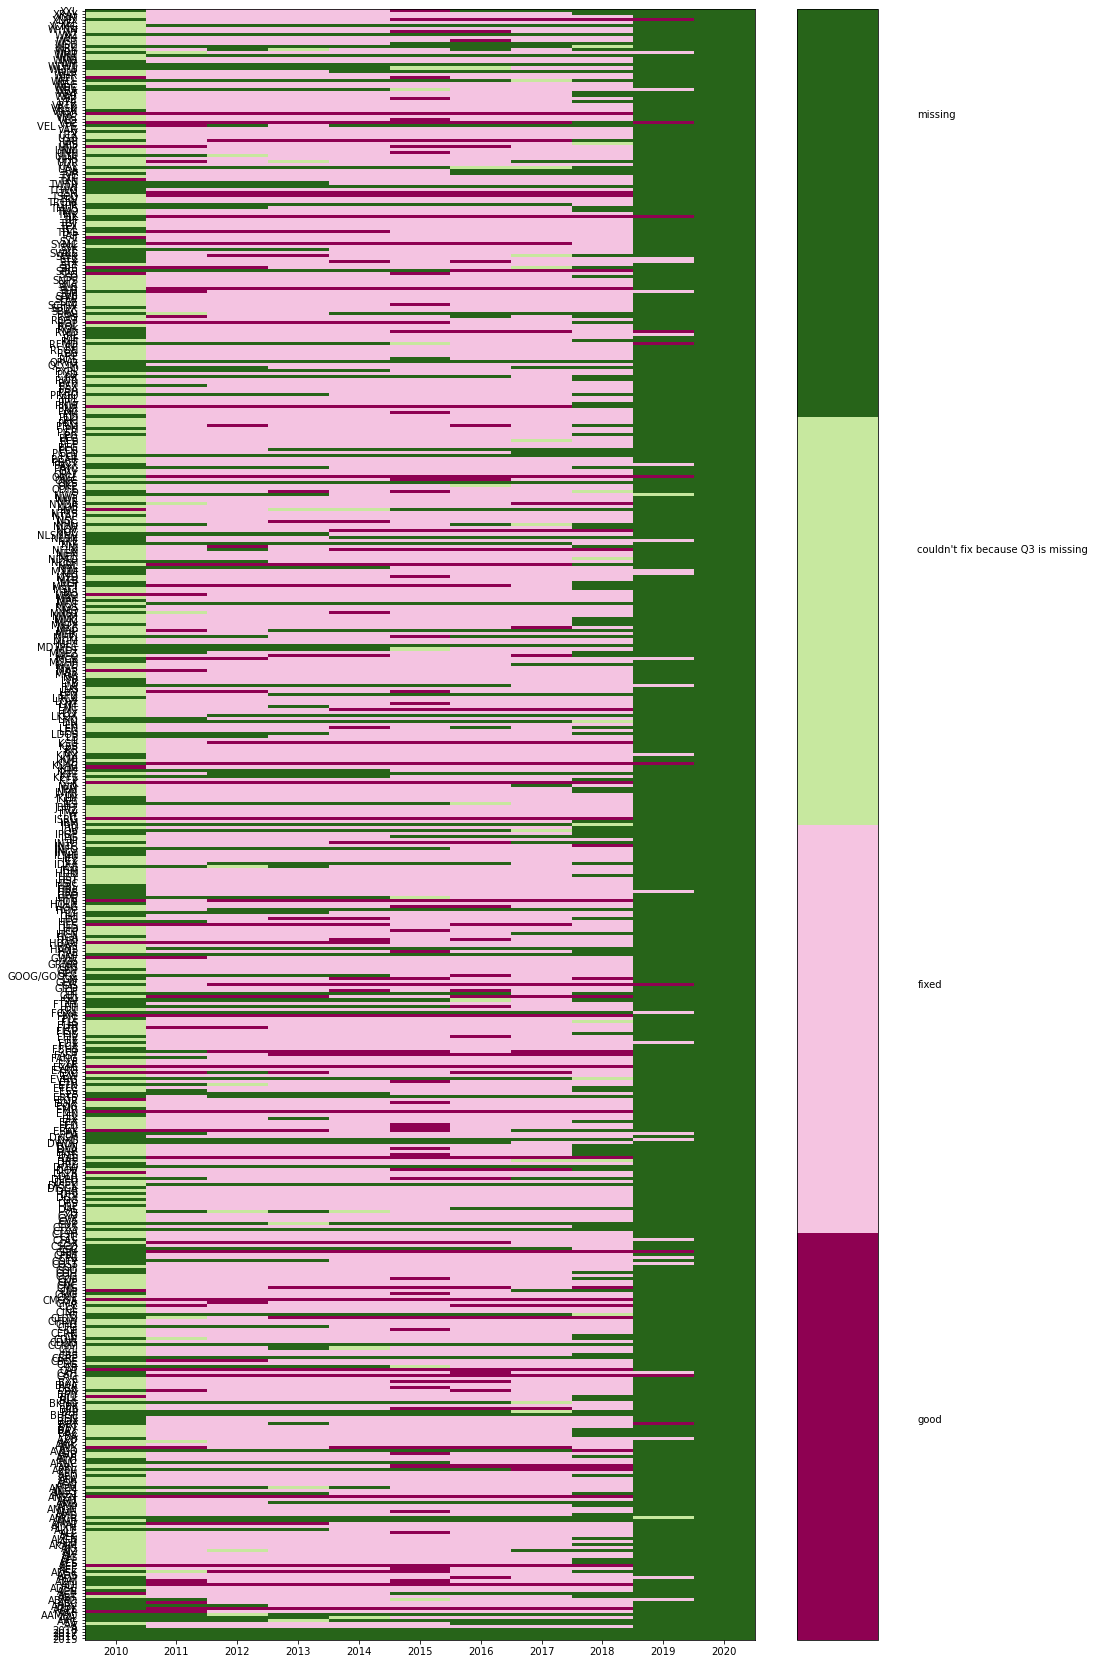

In [22]:
import matplotlib.pyplot as plt
from pylab import cm
cmap = cm.get_cmap('PiYG', 4)
plt.figure(figsize=(15,30))
plt.imshow(msng, origin = 'uppper', cmap=cmap, aspect='auto')

x_label_list = uq_fy
y_label_list = uq_sym

plt.gca().set_xticks(range(len(uq_fy)))
plt.gca().set_yticks(range(len(uq_sym)))

plt.gca().set_yticklabels(y_label_list)
plt.gca().set_xticklabels(x_label_list)
cbar = plt.colorbar()

for index, label in enumerate([ "good", "fixed", "couldn't fix because Q3 is missing", "missing"]):
    x = 4.45
    y = (2 * index + 1) / 2.5
    cbar.ax.text(x, y, label)
cbar.set_ticks([])

# as you can see, data is still patchy
- lots of missing data that couldn't be fixed
- only from 2011
- only until 2018
- a still lots of holes
- forget this, and use the macrotrends notebook and the code in my StockScraperMacroTrends repo

In [89]:
dd[(dd.symbol=='AOS') & (dd.period_focus=='FY')].sort_values(by=['symbol', 'fiscal_year', 'period_focus'])

,symbol,end_date,period_focus,fiscal_year,doc_type,revenues,net_income,eps_basic,dividend,assets,cur_assets,cur_liab,equity,shares_outstanding,shares_issued,avgPr,BVPS,PE,PB,LA,ROS,ROE,ROA,PS,DE,ind,CurrRat,ProfitMargin
0,AOS,2010-12-31,FY,2010,10-K,1.489300e+09,111700000.0,2.44,0.0,2.112000e+09,896000000.0,536800000.0,881400000.0,NaN,40195162.0,9.73,NaN,3.99,NaN,0.6,0.075002,0.13,0.12,NaN,1.4,Industrials,1.67,0.08


In [96]:
dd

,symbol,end_date,period_focus,fiscal_year,doc_type,revenues,net_income,eps_basic,dividend,assets,cur_assets,cur_liab,equity,shares_outstanding,shares_issued,avgPr,BVPS,PE,PB,LA,ROS,ROE,ROA,PS,DE,ind,CurrRat,ProfitMargin
0,AOS,2010-12-31,FY,2010,10-K,1.489300e+09,111700000.0,2.44,0.00,2.112000e+09,8.960000e+08,5.368000e+08,8.814000e+08,NaN,40195162.0,9.73,NaN,3.99,NaN,0.60,0.075002,0.13,0.12,NaN,1.40,Industrials,1.67,0.08
2,AOS,2011-03-31,Q1,2011,10-Q,4.174000e+08,41000000.0,0.89,0.14,2.205300e+09,9.870000e+08,5.554000e+08,9.219000e+08,NaN,40197482.0,10.77,NaN,12.10,NaN,0.56,0.098227,0.04,0.04,NaN,1.39,Industrials,1.78,0.10
1,AOS,2011-06-30,Q2,2011,10-Q,4.053000e+08,50300000.0,1.09,0.14,2.143100e+09,9.912000e+08,5.359000e+08,9.698000e+08,NaN,40421725.0,10.24,NaN,9.39,NaN,0.54,0.124106,0.05,0.05,NaN,1.21,Industrials,1.85,0.12
4,APD,2010-12-31,Q1,2011,10-Q,2.391700e+09,268600000.0,1.25,0.49,1.345970e+10,2.870200e+09,1.937100e+09,5.977200e+09,214919795.0,249455584.0,83.99,27.81,67.19,3.02,0.67,0.112305,0.04,0.09,7.55,1.25,Materials,1.48,0.11
3,APD,2011-03-31,Q2,2011,10-Q,2.501300e+09,304300000.0,1.42,0.58,1.382070e+10,2.976500e+09,2.211300e+09,5.999200e+09,211896649.0,249455584.0,82.62,28.31,58.18,2.92,0.74,0.121657,0.05,0.10,7.00,1.30,Materials,1.35,0.12


In [57]:
since = 2014
n_years = 4
for ticker in np.unique(dd.symbol).tolist():
    profit_percent = get_profitability(ticker, since, n_years)
    print(ticker, profit_percent)




AAPL 28.59
MCD 19.8
MSFT 32.42
XOM -4.08
